In [1]:
import numpy as np
import fdringdown as rd
import gwsurrogate as gws

import matplotlib.pyplot as plt
import rcparams
plt.rcParams.update(rcparams.params)

import matplotlib.colors
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection

from cmcrameri import cm

import astropy.constants as const
G, c, M_sun, pc = const.G.value, const.c.value, const.M_sun.value, const.pc.value

/home/efinch/miniconda3/envs/ringdown/lib/python3.8/site-packages/gwtools/rotations.py:63: UserWarning: Could not import GWFrames, needed for rotations module
  _warnings.warn("Could not import GWFrames, needed for rotations module")
/home/efinch/miniconda3/envs/ringdown/lib/python3.8/site-packages/gwtools/__init__.py:11: UserWarning: Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.
  _warnings.warn("Could not import rotations, decompositions, or fitfuncs. These are not needed by GWSurrogate.")


setting __package__ to gwsurrogate.new so relative imports work
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new
setting __package__ to gwsurrogate.new so relative imports work
setting __package__ to gwsurrogate.new so relative imports work


In [2]:
# Load the surrogate
sur = gws.LoadSurrogate('NRSur7dq4')

Loaded NRSur7dq4 model


In [3]:
# Evaluate the surrogate 
times, h, dyn = sur(
    q=1.2, 
    chiA0=[0,0,0.3], 
    chiB0=[0,0,-0.4], 
    f_low=0, 
    dt=0.1, 
    inclination=0
    )

# Just look at the plus polarization
h_plus = np.real(h)

# Cross polarization in background?
h_cross = -np.imag(h)

In [4]:
# Use the projected waveform

# Create the event class
event = rd.GWevent('GW150914')

# Get the event GPS time
gps = event.parameters['GPS']

# Project onto interferometer
for IFO in event.IFO_list:
    if IFO.name == 'H1':
        H1 = IFO
        
h_projected = H1.project(
    h_plus - 1j*h_cross, 
    1.95, 
    -1.27, 
    gps, 
    0.82,
    )


Loading file H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5
Loading file L-L1_GWOSC_4KHZ_R1-1126257415-4096.hdf5


In [5]:
# Split the line up into sections depending on how we want to colour it
# ============================================================================
inspiral_mask = times <= -25
inspiral = h_projected[inspiral_mask]

inspiral_merger_mask = (times >= -26) & (times <= -9)
inspiral_merger = h_projected[inspiral_merger_mask]
i_m_times = times[inspiral_merger_mask]

merger_mask = (times >= -10) & (times <= 10)
merger = h_projected[merger_mask]

merger_ringdown_mask = (times >= 9) & (times <= 20)
merger_ringdown = h_projected[merger_ringdown_mask]
m_r_times = times[merger_ringdown_mask]

ringdown_mask = times >= 19
ringdown = h_projected[ringdown_mask]

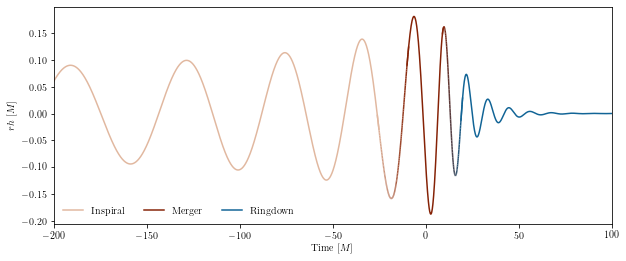

In [6]:
fig, ax = plt.subplots(figsize=(10,4))

# ax.plot(times, h_cross, c='k', alpha=0.1)

# We need the RBG colours for the colour map
cmap = cm.vik
# inspiral_colour = cmap(0.2)[:-1] # matplotlib.colors.to_rgb('C0')
# merger_colour = cmap(0.5)[:-1] # matplotlib.colors.to_rgb('C1')
# ringdown_colour = cmap(0.8)[:-1] # matplotlib.colors.to_rgb('C2')
inspiral_colour = cmap(0.6)[:-1] # matplotlib.colors.to_rgb('C0')
merger_colour = cmap(0.9)[:-1] # matplotlib.colors.to_rgb('C1')
ringdown_colour = cmap(0.2)[:-1] # matplotlib.colors.to_rgb('C2')
# inspiral_colour = (0.005193, 0.098238, 0.349842)
# merger_colour = (0.339469, 0.461685, 0.279468)
# ringdown_colour = (0.983574, 0.64959, 0.538819)

# The solid colour regions
ax.plot(times[inspiral_mask], inspiral, c=inspiral_colour)
ax.plot(times[merger_mask], merger, c=merger_colour)
ax.plot(times[ringdown_mask], ringdown, c=ringdown_colour)

# Colour maps
# ===========

# Create colour maps from list
i_m_colours = [inspiral_colour, merger_colour]
i_m_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", i_m_colours)

m_r_colours = [merger_colour, ringdown_colour]
m_r_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", m_r_colours)

# Line segments
# =============

# Create a set of line segments so that we can color them individually
i_m_points = np.array([i_m_times, inspiral_merger]).T.reshape(-1, 1, 2)
i_m_segments = np.concatenate([i_m_points[:-1], i_m_points[1:]], axis=1)

m_r_points = np.array([m_r_times, merger_ringdown]).T.reshape(-1, 1, 2)
m_r_segments = np.concatenate([m_r_points[:-1], m_r_points[1:]], axis=1)

# Create a continuous norm to map from data points to colours
i_m_norm = plt.Normalize(i_m_times[0], i_m_times[-1])
i_m_lc = LineCollection(i_m_segments, cmap=i_m_cmap, norm=i_m_norm)

m_r_norm = plt.Normalize(m_r_times[0], m_r_times[-1])
m_r_lc = LineCollection(m_r_segments, cmap=m_r_cmap, norm=m_r_norm)

# Set the values used for colormapping
i_m_lc.set_array(i_m_times)
m_r_lc.set_array(m_r_times)

# Add lines to the figure
i_m_line = ax.add_collection(i_m_lc)
m_r_line = ax.add_collection(m_r_lc)

ax.set_xlabel('Time $[M]$')
ax.set_xlim(-200, times[-1])

ax.set_ylabel('$rh\ [M]$')

custom_lines = [Line2D([0], [0], color=c) for c in [inspiral_colour, merger_colour, ringdown_colour]]
ax.legend(
    custom_lines, 
    ['Inspiral', 'Merger', 'Ringdown'], 
    frameon=False, 
    ncol=3, 
    loc='lower left', 
    # bbox_to_anchor=(0.49,-0.12)
    )

fig.savefig('td_waveform.pdf', bbox_inches='tight')

In [7]:
z = event.parameters['redshift']
m1, m2 = (1+z)*event.parameters['mass_1_source'], (1+z)*event.parameters['mass_2_source']
M = m1 + m2
D = event.parameters['luminosity_distance']

In [8]:
M

72.15800000000002

In [9]:
M*M_sun

1.4347967944982998e+32

In [10]:
D

440.0

In [11]:
D*pc*1e6

1.3576981358562016e+25

In [12]:
M_seconds = M*M_sun*G/c**3
print(M_seconds)

0.0003554135757998986


In [13]:
# Ringdown duration
50*M_seconds

0.01777067878999493

In [14]:
M_over_r = M_seconds/(D*1e6*pc/c)
print(M_over_r)

7.847864461302172e-21


In [15]:
# Peak strain amplitude
M_over_r*0.2

1.5695728922604345e-21